<a href="https://colab.research.google.com/github/qingyuan-wu/Praxis-III/blob/ML-model/plastics_identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plastics Sorting
Given an image, this program sorts it as either PET or non-PET. This is expected to work for plastics that are crumpled.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%shell
# /content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/WaDaBa-Processed/02-PEHD/0010_a02b01c1d0e0f1g0h0.jpg
# /content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/WaDaBa-Processed/02-PEHD
mv "/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/WaDaBa-Processed/02-PEHD"/* "/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/WaDaBa-Processed/02-NOT-PET"
mv "/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/WaDaBa-Processed/05-PP"/* "/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/WaDaBa-Processed/02-NOT-PET"
mv "/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/WaDaBa-Processed/06-PS"/* "/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/WaDaBa-Processed/02-NOT-PET"
mv "/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/WaDaBa-Processed/07-Other"/* "/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/WaDaBa-Processed/02-NOT-PET"


In [ ]:
class CNN_V0(nn.Module):
    name = "CNN_V0"
    def __init__(self):
        # input dimensions: 1277x1277
        super(CNN_V0, self).__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 16, 6), # 1272
            nn.BatchNorm2d(16), # must be output channel of previous layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(8, 8) # 159
        )
        # now size 636x636*16
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(16, 16, 3), # 157
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 78
            nn.Dropout2d(p=0.05),
        )
        # now size 317*317*16
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(16, 32, 3), # 76
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 38
        )
        # now size 157*157*32
        self.conv_layer_4 = nn.Sequential(
            nn.Conv2d(32, 32, 3), # 36
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 18
            nn.Dropout2d(p=0.05), 
        )
        # now size 77*77*64
        self.conv_layer_5 = nn.Sequential(
            nn.Conv2d(32, 32, 3), # 16
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 8
        )
        # now size 37*37*64
        # self.conv_layer_6 = nn.Sequential(
        #     nn.Conv2d(32, 32, 3), # 16
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(2, 2), # 8
        #     nn.Dropout2d(p=0.05),
        # )
        # now size 17*17*128
        self.fc = nn.Sequential(
            nn.Linear(8*8*32, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
        x = self.conv_layer_5(x)
        # x = self.conv_layer_6(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_acc.csv".format(path))
    val_err = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def get_data_loader(paths, batch_size=64, splits=[0.8,0.1,0.1]):
    '''
    Generate test, validation, and training loaders giving a list of dataset in paths
    return: test_loader, train_loader, val_loader each of type DataLoader
    '''
    if sum(splits) != 1.0:
        return "ensure training-validation-test split adds up to 1!"

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])
    dataset = torchvision.datasets.ImageFolder(paths[0], transform=transform)
    for path in paths[1:]:
        cur_set = torchvision.datasets.ImageFolder(path, transform=transform)
        dataset = torch.utils.data.ConcatDataset([dataset, cur_set])
    size = len(dataset)
    print(f"total length of dataset: {size}")

    # perform split
    l1, l2 = int(size*splits[0]), int(size*splits[1])
    l3 = size - l1 - l2
    if int(splits[0]) == 1:
        # toy set: no splits
        # much specify batch size else it defaults to 1 !!!
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1), [], []
    print(f"training, validation, and test set each has {l1}, {l2}, {l3} images")
    train_set, val_set, test_set = torch.utils.data.random_split(
        dataset, [l1, l2, l3],
        generator=torch.Generator().manual_seed(999)
    )

    # note, labels are automatically generated due to the folder naming convention
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)
    
    return train_loader, val_loader, test_loader

In [ ]:
def get_accuracy(net, loader, criterion=nn.CrossEntropyLoss()):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         accuracy: A scalar for the avg classification accuracy over the set
         loss: A scalar for the average loss function over the set
     """
    torch.manual_seed(1000)
    total_loss = 0.0
    total = 0
    correct = 0
    for i, (inputs, labels) in enumerate(loader):
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        pred = outputs.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += len(labels)
        total_loss += loss.item()
    accuracy = correct/total
    loss = total_loss/(i+1)
    return accuracy, loss

In [ ]:
path = ["/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/WaDaBa-Processed"]

train_loader, val_loader, test_loader = get_data_loader(path, batch_size=64)

total length of dataset: 4000
training, validation, and test set each has 3200, 400, 400 images


torch.Size([64, 3, 1277, 1277])


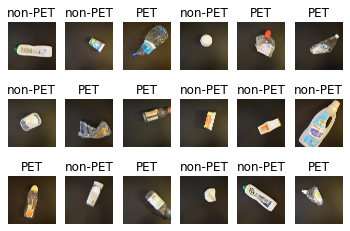

In [ ]:
def visualize(loader):
    types = ["PET", "non-PET"]
    dataiter = iter(loader)
    images, labels = dataiter.next()
    for k in range(18):
        if k == 0:
            print(images.shape)
        image = images[k]
        label = labels[k]
        # place the colour channel at the end, instead of at the beginning
        img = np.transpose(image, [1,2,0])
        # normalize pixel intensity values to [0, 1]
        img = img / 2 + 0.5
        plt.subplot(3, 6, k+1)
        plt.axis('off')
        plt.title(types[labels[k].item()])
        plt.imshow(img)

visualize(train_loader)

In [ ]:
# Helper function for train - get model name to save to disk
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def train(model, path, batch_size=64, learning_rate=0.001, num_epochs=30, starting_epoch=0):
    '''
    Train NN model model with batch_size, learning_rate, num_epochs
    Use SGD as optimizer and cross entropy as loss function (with softmax)
    toy_set is a batch of 27 images to validate that the network is sound

    Return:
        if toy_set set to True, the function returns only the training accuracy and loss
        The default is to train the real data set, which then returns both training and validation accuracy and loss
    '''
    import time
    torch.manual_seed(1000)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # full dataset of plastics
    train_loader, val_loader, test_loader = get_data_loader([path], batch_size=batch_size, splits=[0.8,0.1,0.1])

    train_acc, train_loss = [], []
    val_acc, val_loss = [], []

    t_loss = 0
    total = 0
    correct = 0
    start_time = time.time()
    for epoch in range(starting_epoch, num_epochs + starting_epoch):
        for i, (images, labels) in enumerate(train_loader):
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            # training accuracies
            pred = outputs.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += len(labels)
            t_loss += loss.item()

        # get validation accuracies
        v_acc, v_loss = get_accuracy(model, val_loader, criterion)
        val_acc.append(v_acc)
        val_loss.append(v_loss)

        # calculate training accuracies
        t_acc = correct/total
        t_loss = t_loss/(i+1)
        train_acc.append(t_acc)
        train_loss.append(t_loss)
        
        print(f"completed epoch {epoch+1}/{num_epochs}, training loss: {loss.item():.4f} | training accuracy: {t_acc:.4f}", end="")
        print(f" | validation loss: {v_loss:.4f} | validation accuracy: {v_acc:.4f}")

        # For each epoch: Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
        path_in_drive = f"/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/CNN-Models/{model_path}"
        try:
            torch.save(model.state_dict(), path_in_drive)
        except Exception as e:
            print(f"could not save to {path_in_drive}. Download manually instead.")
            print(e)

        t_loss = 0
        total = 0
        correct = 0
    end_time = time.time()
    total_time = end_time - start_time
    print(f"training completed! Time: {total_time:.2f} s = {(total_time/60):.2f} min")
    
    try:
        np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
        np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
        np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
        np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    except Exception as e:
        print("could not save csv files")
        print(e)
    return train_acc, train_loss, val_acc, val_loss

In [ ]:
model = CNN_V0()
train_acc, train_loss, val_acc, val_loss = train(model, batch_size=32, num_epochs=10)

total length of dataset: 4000
training, validation, and test set each has 3200, 400, 400 images
completed epoch 1/10, training loss: 0.4002 | training accuracy: 0.7406 | validation loss: 0.3793 | validation accuracy: 0.8400
completed epoch 2/10, training loss: 0.3774 | training accuracy: 0.8516 | validation loss: 0.3237 | validation accuracy: 0.8750
completed epoch 3/10, training loss: 0.3633 | training accuracy: 0.8825 | validation loss: 0.2901 | validation accuracy: 0.8975
completed epoch 4/10, training loss: 0.2888 | training accuracy: 0.9128 | validation loss: 0.2469 | validation accuracy: 0.9100
completed epoch 5/10, training loss: 0.2613 | training accuracy: 0.9256 | validation loss: 0.2332 | validation accuracy: 0.9075
completed epoch 6/10, training loss: 0.2557 | training accuracy: 0.9381 | validation loss: 0.2277 | validation accuracy: 0.9100
completed epoch 7/10, training loss: 0.2528 | training accuracy: 0.9506 | validation loss: 0.2084 | validation accuracy: 0.9100
complete

Keep training for a few more epochs to see if validation accuracy improves.

In [ ]:
class CNN_V0_Cont(nn.Module):
    name = "CNN_V0_Cont"
    def __init__(self):
        # input dimensions: 1277x1277
        super(CNN_V0_Cont, self).__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 16, 6), # 1272
            nn.BatchNorm2d(16), # must be output channel of previous layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(8, 8) # 159
        )
        # now size 636x636*16
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(16, 16, 3), # 157
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 78
            nn.Dropout2d(p=0.05),
        )
        # now size 317*317*16
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(16, 32, 3), # 76
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 38
        )
        # now size 157*157*32
        self.conv_layer_4 = nn.Sequential(
            nn.Conv2d(32, 32, 3), # 36
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 18
            nn.Dropout2d(p=0.05), 
        )
        # now size 77*77*64
        self.conv_layer_5 = nn.Sequential(
            nn.Conv2d(32, 32, 3), # 16
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 8
        )
        # now size 17*17*128
        self.fc = nn.Sequential(
            nn.Linear(8*8*32, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
        x = self.conv_layer_5(x)
        # x = self.conv_layer_6(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
model_path = "/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/CNN-Models/model_CNN_V0_bs32_lr0.001_epoch9"

model = CNN_V0_Cont()
model.load_state_dict(torch.load(model_path))

train_acc, train_loss, val_acc, val_loss = train(model, batch_size=32, num_epochs=2)

total length of dataset: 4000
training, validation, and test set each has 3200, 400, 400 images
completed epoch 1/2, training loss: 0.2061 | training accuracy: 0.9503 | validation loss: 0.1706 | validation accuracy: 0.9400
completed epoch 2/2, training loss: 0.0793 | training accuracy: 0.9856 | validation loss: 0.1786 | validation accuracy: 0.9475
training completed! Time: 2928.47 s = 48.81 min


Train for another 3 more epochs:

In [ ]:
train_acc, train_loss, val_acc, val_loss = train(model, batch_size=32, num_epochs=3)

total length of dataset: 4000
training, validation, and test set each has 3200, 400, 400 images
completed epoch 1/3, training loss: 0.1303 | training accuracy: 0.9722 | validation loss: 0.1486 | validation accuracy: 0.9475
completed epoch 2/3, training loss: 0.0590 | training accuracy: 0.9897 | validation loss: 0.1721 | validation accuracy: 0.9475
completed epoch 3/3, training loss: 0.0630 | training accuracy: 0.9925 | validation loss: 0.1517 | validation accuracy: 0.9575
training completed! Time: 4462.48 s = 74.37 min


### V1 - More Complex Network

In [ ]:
class CNN_V1(nn.Module):
    name = "CNN_V1"
    def __init__(self):
        # input dimensions: 1277x1277
        super(CNN_V1, self).__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 16, 6), # 1272
            nn.BatchNorm2d(16), # must be output channel of previous layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4, 4) # 318
        )
        # now size 636x636*16
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(16, 16, 3), # 316
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 158
            nn.Dropout2d(p=0.05),
        )
        # now size 317*317*16
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(16, 32, 3), # 156
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 78
        )
        # now size 157*157*32
        self.conv_layer_4 = nn.Sequential(
            nn.Conv2d(32, 32, 3), # 76
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 38
            nn.Dropout2d(p=0.05), 
        )
        # now size 77*77*64
        self.conv_layer_5 = nn.Sequential(
            nn.Conv2d(32, 64, 3), # 36
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 18
        )
        # now size 37*37*64
        self.conv_layer_6 = nn.Sequential(
            nn.Conv2d(64, 64, 3), # 16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 8
            nn.Dropout2d(p=0.05),
        )
        # now size 17*17*128
        self.fc = nn.Sequential(
            nn.Linear(8*8*64, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
        x = self.conv_layer_5(x)
        x = self.conv_layer_6(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
model_v1 = CNN_V1()
train_acc, train_loss, val_acc, val_loss = train(model_v1, batch_size=32, num_epochs=10)

total length of dataset: 4000
training, validation, and test set each has 3200, 400, 400 images
completed epoch 1/10, training loss: 0.4569 | training accuracy: 0.6856 | validation loss: 0.4095 | validation accuracy: 0.8100
completed epoch 2/10, training loss: 0.2641 | training accuracy: 0.8491 | validation loss: 0.2879 | validation accuracy: 0.8850
completed epoch 3/10, training loss: 0.2000 | training accuracy: 0.8931 | validation loss: 0.2557 | validation accuracy: 0.8950
completed epoch 4/10, training loss: 0.1829 | training accuracy: 0.9134 | validation loss: 0.2449 | validation accuracy: 0.9025
completed epoch 5/10, training loss: 0.1855 | training accuracy: 0.9322 | validation loss: 0.2338 | validation accuracy: 0.9025
completed epoch 6/10, training loss: 0.1124 | training accuracy: 0.9444 | validation loss: 0.2353 | validation accuracy: 0.9050
completed epoch 7/10, training loss: 0.0784 | training accuracy: 0.9513 | validation loss: 0.2500 | validation accuracy: 0.9075
complete

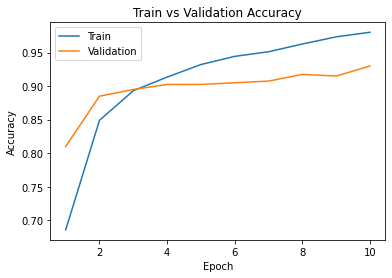

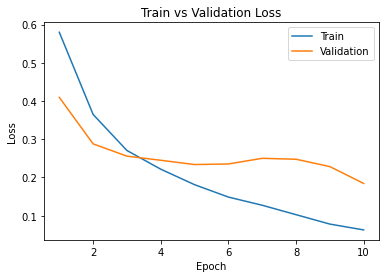

In [ ]:
plot_training_curve("/content/model_CNN_V1_bs32_lr0.001_epoch9")

There is significant overfitting with the above "V1" network. This is likely because the network is too complex for a binary type classification problem. Our original model obtained a higher accuracy and there is less overfitting - evidence that it will work better with tesing and real-world images.

### Test Set Accuracy

In [ ]:
model_path = "/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/CNN-Models/model_CNN_V0_bs32_lr0.001_epoch9"

model_v0 = CNN_V0()
model_v0.load_state_dict(torch.load(model_path))
model_v0.eval()
with torch.no_grad():
    test_acc, test_loss = get_accuracy(model_v0, test_loader)

In [ ]:
print(f"accuracy on test set: {test_acc} | loss on test set: {test_loss}")

accuracy on test set: 0.945 | loss on test set: 0.1664645985833236


### Try a model with a smaller input size
First process the images again to have size 256x256 instead of 1277x1277

In [ ]:
from PIL import Image

In [ ]:
path = "/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/WaDaBa-Processed"
out_path = "/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/WaDaBa-256x256"
PET = "/01-PET/"
NOT_PET = "/02-NOT-PET/"
for im in os.listdir(path + PET):
    Image.open(path + PET + im).resize((256,256)).save(out_path + PET + im)
for im in os.listdir(path + NOT_PET):
    Image.open(path + NOT_PET + im).resize((256,256)).save(out_path + NOT_PET + im)

In [ ]:
class CNN_256x256(nn.Module):
    name = "CNN_256x256"
    def __init__(self):
        # input dimensions: 256x256
        super(CNN_256x256, self).__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 16, 3), # 254
            nn.BatchNorm2d(16), # must be output channel of previous layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2) # 127
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(16, 16, 3), # 125
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 62
            nn.Dropout2d(p=0.05),
        )
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(16, 32, 3), # 60
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 30
        )
        self.conv_layer_4 = nn.Sequential(
            nn.Conv2d(32, 32, 3), # 28
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 14
            nn.Dropout2d(p=0.05), 
        )
        self.conv_layer_5 = nn.Sequential(
            nn.Conv2d(32, 64, 3), # 12
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 6
        )

        self.fc = nn.Sequential(
            nn.Linear(64*6*6, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
        x = self.conv_layer_5(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
model_v3 = CNN_256x256()
path = "/content/gdrive/MyDrive/Praxis 3/Plastics-Tracking/WaDaBa-256x256/"
train_acc, train_loss, val_acc, val_loss = train(model_v3, path, batch_size=32, num_epochs=8)

total length of dataset: 4000
training, validation, and test set each has 3200, 400, 400 images
completed epoch 1/8, training loss: 0.4065 | training accuracy: 0.7222 | validation loss: 0.3942 | validation accuracy: 0.8350
completed epoch 2/8, training loss: 0.3003 | training accuracy: 0.8403 | validation loss: 0.3405 | validation accuracy: 0.8375
completed epoch 3/8, training loss: 0.3311 | training accuracy: 0.8838 | validation loss: 0.3314 | validation accuracy: 0.8500
completed epoch 4/8, training loss: 0.2569 | training accuracy: 0.9103 | validation loss: 0.2912 | validation accuracy: 0.8700
completed epoch 5/8, training loss: 0.2371 | training accuracy: 0.9328 | validation loss: 0.2807 | validation accuracy: 0.8750
completed epoch 6/8, training loss: 0.2402 | training accuracy: 0.9406 | validation loss: 0.2488 | validation accuracy: 0.8900
completed epoch 7/8, training loss: 0.1561 | training accuracy: 0.9469 | validation loss: 0.2247 | validation accuracy: 0.9075
completed epoch

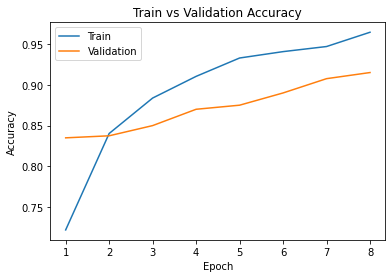

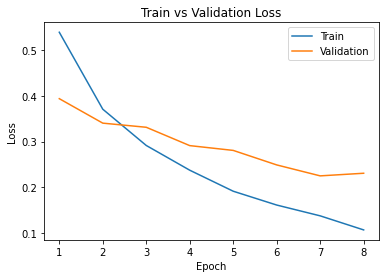

In [ ]:
plot_training_curve("/content/model_CNN_256x256_bs32_lr0.001_epoch7")

In [ ]:
train_acc, train_loss, val_acc, val_loss = train(model_v3, path, batch_size=32, num_epochs=8, starting_epoch=8)

total length of dataset: 4000
training, validation, and test set each has 3200, 400, 400 images
completed epoch 9/8, training loss: 0.2306 | training accuracy: 0.9406 | validation loss: 0.1968 | validation accuracy: 0.9200
completed epoch 10/8, training loss: 0.1355 | training accuracy: 0.9728 | validation loss: 0.2153 | validation accuracy: 0.9200
completed epoch 11/8, training loss: 0.0780 | training accuracy: 0.9812 | validation loss: 0.2063 | validation accuracy: 0.9225
completed epoch 12/8, training loss: 0.0711 | training accuracy: 0.9891 | validation loss: 0.1930 | validation accuracy: 0.9275
completed epoch 13/8, training loss: 0.0640 | training accuracy: 0.9900 | validation loss: 0.1897 | validation accuracy: 0.9300
completed epoch 14/8, training loss: 0.0543 | training accuracy: 0.9859 | validation loss: 0.2067 | validation accuracy: 0.9200
completed epoch 15/8, training loss: 0.0229 | training accuracy: 0.9934 | validation loss: 0.1962 | validation accuracy: 0.9300
completed

Note that the blow training curves are continuations of the previous training curves. The model began to overfit clearly.

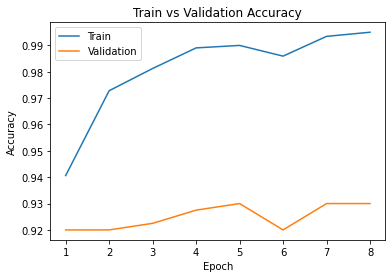

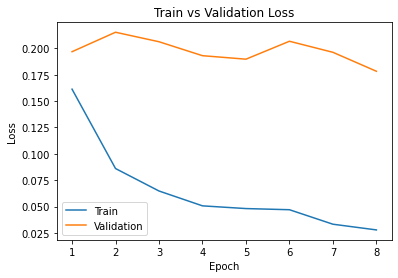

In [ ]:
plot_training_curve("/content/model_CNN_256x256_bs32_lr0.001_epoch15")